In [1]:
#### ALL NOTEBOOK SHOULD HAVE SOME VERSION OF THIS #####################################
########################################################################################
%load_ext autoreload
%autoreload 2
import os
import sys

currentdir = os.getcwd()
# go to root directory. change the # of os.path.dirnames based on where currentdir is
parentdir = os.path.dirname(os.path.dirname(currentdir)) 
# chek where I'm at. if I go too far up the tree, go back
if 'Protein-Purification-Model-Public' not in parentdir: parentdir = currentdir
if parentdir not in sys.path: sys.path.insert(0,parentdir)
########################################################################################

In [2]:
import utils
from visualization.simple_data_vis import histograms
import surrogate_models.dab_nn_defs as engine
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow as tf

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
# load data from just-private/data
filename = 'mol_res_scan_results_7.csv'
data = utils.load_data(parentdir, filename)

# since currently data is just one big dataframe, select model inputs as X and purity, yield as Y
x = [*data.columns[:2],*data.columns[4:]]
y = data.columns[2:4]

In [ ]:
# _,_ = histograms(data,x,y)

In [4]:
# split data into train and test
train_x, test_x, train_y, test_y = utils.chroma_train_test_split(data, x,y)

In [5]:
train_x, test_x = utils.preprocessing([train_x, test_x], standarize = True, skip = ['cut 1','cut 2'])
train = (train_x, train_y)
test = (test_x, test_y)

In [6]:
# define models to test out
lr = engine.create_deterministic_linear_regressor(
    FEATURE_NAMES = x,
    TARGET_NAMES = y, 
    name = 'DLR_'+filename[:-4]
)

dnn = engine.create_deterministic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    hidden_units = [16,8,4],
    name = 'DNN_'+filename[:-4]
)

pnn = engine.create_probabilistic_nn(
    FEATURE_NAMES = x,
    TARGET_NAMES = y,
    train_size = len(train[0]),
    hidden_units = [4,],
    name = 'PNN_'+filename[:-4]
)

models = [lr, dnn, pnn]

In [8]:
dnn.summary()

Model: "DNNboston"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 18)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                304       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 36        
_________________________________________________________________
output (Dense)               (None, 2)                 10        
Total params: 486
Trainable params: 486
Non-trainable params: 0
_________________________________________________________________


In [9]:
# train all the models under the same conditions
learning_rate = 0.1
epochs = 300
optimizer = 'Adam'

for m in models:
    engine.run_experiment(
        model = m, 
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam,
        learning_rate = learning_rate,
        num_epochs = epochs,
        train_dataset = train, 
        test_dataset = test,
        verbose = 0
        )

Start training the model DLRboston ...
Model training finished.
Train MSE: 0.007
Evaluating model performance...
Test MSE: 0.006
Start training the model DNNboston ...
Model training finished.
Train MSE: 0.002
Evaluating model performance...
Test MSE: 0.001
Start training the model PNNboston ...
Model training finished.
Train MSE: 0.037
Evaluating model performance...
Test MSE: 0.034


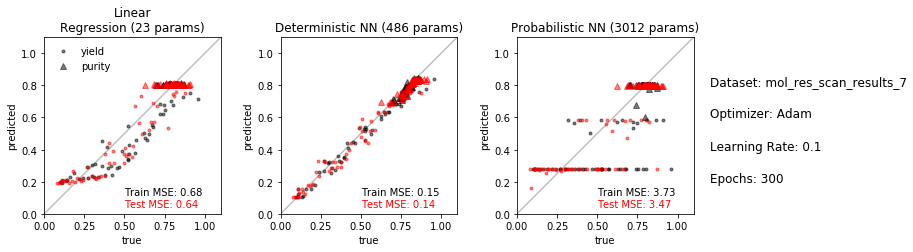

In [63]:
import matplotlib.pyplot as plt
import numpy as np 

N = 50

sample_inputs_train = train[0].sample(N)
sample_outputs_train = train[1].loc[sample_inputs_train.index]
sample_inputs_test = test[0].sample(N)
sample_outputs_test = test[1].loc[sample_inputs_test.index]

colors = ['k','r']
titles = ['Linear\nRegression','Deterministic NN','Probabilistic NN']
plt.figure(figsize = (10,30))
for i,m in enumerate(models):
    plt.subplot(1,len(models),i+1)

    plt.errorbar(sample_outputs_train.to_numpy()[:,0], m(sample_inputs_train.to_numpy()).numpy()[:,0],
    marker = '.', color = 'k', alpha = 0.5, ls = 'none',  label = y[0])

    plt.errorbar(sample_outputs_test.to_numpy()[:,0], m(sample_inputs_test.to_numpy()).numpy()[:,0],
    marker = '.', color = 'r', alpha = 0.5, ls = 'none')

    plt.errorbar(sample_outputs_train.to_numpy()[:,1], m(sample_inputs_train.to_numpy()).numpy()[:,1],
    marker = '^', color = 'k', alpha = 0.5, ls = 'none', label = y[1])

    plt.errorbar(sample_outputs_test.to_numpy()[:,1], m(sample_inputs_test.to_numpy()).numpy()[:,1],
    marker = '^', color = 'r', alpha = 0.5, ls = 'none')

    plt.title(titles[i] + ' ({} params)'.format(utils.count_parameters(m)))
    xmax = 1.1
    plt.gca().set_aspect('equal')
    plt.xlim([0,xmax])
    plt.ylim([0,xmax])
    plt.plot([0,xmax],[0,xmax],'k',alpha=0.25)
    plt.xlabel('true')
    plt.ylabel('predicted')
    if i == 0: plt.legend(frameon = False)

    rmse = m.evaluate(x = train[0], y = train[1], verbose=0)*100
    plt.text(0.5,0.12,f"Train MSE: {round(np.sum(rmse), 2)}", color = 'k')
    rmse = m.evaluate(x = test[0], y = test[1], verbose=0)*100
    plt.text(0.5,0.04,f"Test MSE: {round(np.sum(rmse), 2)}", color = 'r')

plt.tight_layout()
plt.text(2, .80, '.', fontsize=1); 
plt.text(1.20, .80, 'Dataset: '+filename[:-4], fontsize=12)
plt.text(1.20, .60, 'Optimizer: '+optimizer, fontsize=12)
plt.text(1.20, .40, 'Learning Rate: '+str(learning_rate), fontsize=12)
plt.text(1.20, .20, 'Epochs: '+str(epochs), fontsize=12);  

In [ ]:
def model_builder(hp):
    hp_layers = hp.Int('layers', min_value=2, max_value=10)
    hp_units = hp.Int('units', min_value=4, max_value = 32, step=2)
    for L in range(hp_layers):
        hidden_units = [np.ceil(hp_units**(l/L)) for l in range(L)]

    # define Probabilistic Bayesian Neural Network 
    model = engine.create_probablistic_bnn_model(
        FEATURE_NAMES = data.columns[4:],
        TARGET_NAMES = data.columns[2:4], 
        train_size = train_size, 
        n_outputs = y.shape[1],
        hidden_units = hidden_units,
        name = 'PBNN_'+filename
        )

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss=engine.negative_loglikelihood,
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=400,
                     factor=2,
                     directory="surrogate_models/.hypertuning/",
                     project_name='intro_to_kt')

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(train_dataset, validation_data = test_dataset, epochs = 100)

In [ ]:
best = tuner.get_best_models()

In [ ]:
best_distributions = best[0](sample_inputs)
best_means = [i.mean().numpy().tolist() for i in best_distributions]


In [ ]:
best_means

In [ ]:
import matplotlib.pyplot as plt
N = 10

sample_inputs, sample_outputs = list(tf.data.Dataset.from_tensor_slices((train_x.to_dict('list'),train_y.to_dict('list'))).batch(N))[0]

out = []
for i in range(N):
    out.append(prob_bnn_model(sample_inputs))
out = tf.stack(out,-1)

colors = ['k','r']
for i in range(2):
    plt.errorbar(list(sample_outputs.values())[i].numpy(), out[i,:,:,:].numpy().mean(-1),
    yerr = out[i,:,:,:].numpy().std(-1).squeeze(),
    label = data.columns[2:4][i],
    marker = 'o', color = colors[i], alpha = 0.5,
    ls = 'none')
plt.plot([0,1],[0,1],'k',alpha=0.25)
plt.legend(loc='lower right')
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect('equal')
plt.xlabel('true')
plt.ylabel('predicted')


In [ ]:
histograms(train_y.merge(train_x, left_index=True, right_index = True),x,y)